# Libraries & main dataframes loading/creation (price, log returns...)

In [2]:
### LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


### PRICE TIME SERIES DATAFRAME
data = pd.read_csv("/Users/andrei/Documents/asset-allocation-data/processed/2024-02-25/equities_2024-02-25.csv")
data['DATE'] = pd.to_datetime(data['DATE'])
tickers = data.drop("DATE", axis = 1).columns
data['DAY_OF_WEEK'] = data['DATE'].dt.dayofweek


### CALCULATE LOG RETURNS
log_returns = data.set_index('DATE')[tickers].apply(lambda x: np.log(x) - np.log(x.shift(1)))


### REMOVING MISSING VALUES
log_returns_clean = log_returns.dropna()

### LOG RETURNS ADJUSTED FOR FRIDAY-MONDAY CALENDAR DISTANCE
log_returns_adj = log_returns.copy()
log_returns_adj['DAYS_DISTANCE'] = log_returns_adj.index.to_series().diff().dt.days
log_returns_adj[tickers] = log_returns_adj[tickers].div(log_returns_adj['DAYS_DISTANCE'], axis=0)
log_returns_adj.drop("DAYS_DISTANCE", axis = 1, inplace = True)


### FRIDAYS DATA FRAME
fridays_data = data[data['DAY_OF_WEEK'] == 4]
log_returns_fridays = fridays_data.set_index('DATE')[tickers].apply(lambda x: np.log(x) - np.log(x.shift(1)))

# Preliminary data visualization

## Missing values

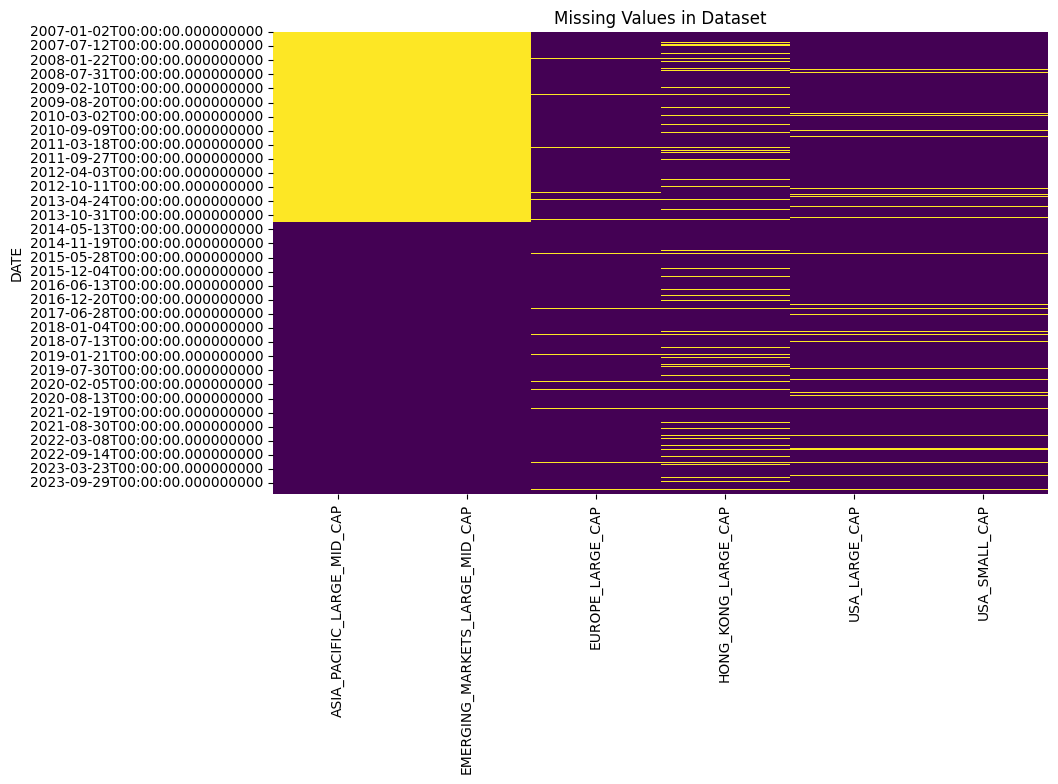

Count of missing values for each column:
ASIA_PACIFIC_LARGE_MID_CAP        361
EMERGING_MARKETS_LARGE_MID_CAP    361
EUROPE_LARGE_CAP                   40
HONG_KONG_LARGE_CAP                88
USA_LARGE_CAP                      41
USA_SMALL_CAP                      41
dtype: int64
Available observations for each column:
ASIA_PACIFIC_LARGE_MID_CAP        525
EMERGING_MARKETS_LARGE_MID_CAP    525
EUROPE_LARGE_CAP                  846
HONG_KONG_LARGE_CAP               798
USA_LARGE_CAP                     845
USA_SMALL_CAP                     845
dtype: int64
Percentage of missing values for each column:
ASIA_PACIFIC_LARGE_MID_CAP        0.407449
EMERGING_MARKETS_LARGE_MID_CAP    0.407449
EUROPE_LARGE_CAP                  0.045147
HONG_KONG_LARGE_CAP               0.099323
USA_LARGE_CAP                     0.046275
USA_SMALL_CAP                     0.046275
dtype: float64


In [2]:
missing_values_df = log_returns.isnull()

### Plotting missing values
plt.figure(figsize=(10, 6))
sns.heatmap(missing_values_df, cmap='viridis', cbar=False)
plt.title('Missing Values in Dataset')
plt.show()

missing_values_count = log_returns_fridays.isnull().sum()

# Display the count of missing values for each column
print("Count of missing values for each column:")
print(missing_values_count)
print("Available observations for each column:")
print(log_returns_fridays.shape[0] - missing_values_count)
print("Percentage of missing values for each column:")
print(missing_values_count / log_returns_fridays.shape[0])

In [7]:
print(pd.DataFrame({'Expected Return': log_returns_clean.mean(),
                    'Standard Deviation of Log Returns': log_returns_clean.std()}))

                                Expected Return  \
ASIA_PACIFIC_LARGE_MID_CAP             0.000259   
EMERGING_MARKETS_LARGE_MID_CAP         0.000168   
EUROPE_LARGE_CAP                       0.000434   
HONG_KONG_LARGE_CAP                   -0.000052   
USA_LARGE_CAP                          0.000541   
USA_SMALL_CAP                          0.000524   

                                Standard Deviation of Log Returns  
ASIA_PACIFIC_LARGE_MID_CAP                               0.009557  
EMERGING_MARKETS_LARGE_MID_CAP                           0.009793  
EUROPE_LARGE_CAP                                         0.011241  
HONG_KONG_LARGE_CAP                                      0.012925  
USA_LARGE_CAP                                            0.011319  
USA_SMALL_CAP                                            0.014453  


## Correlation

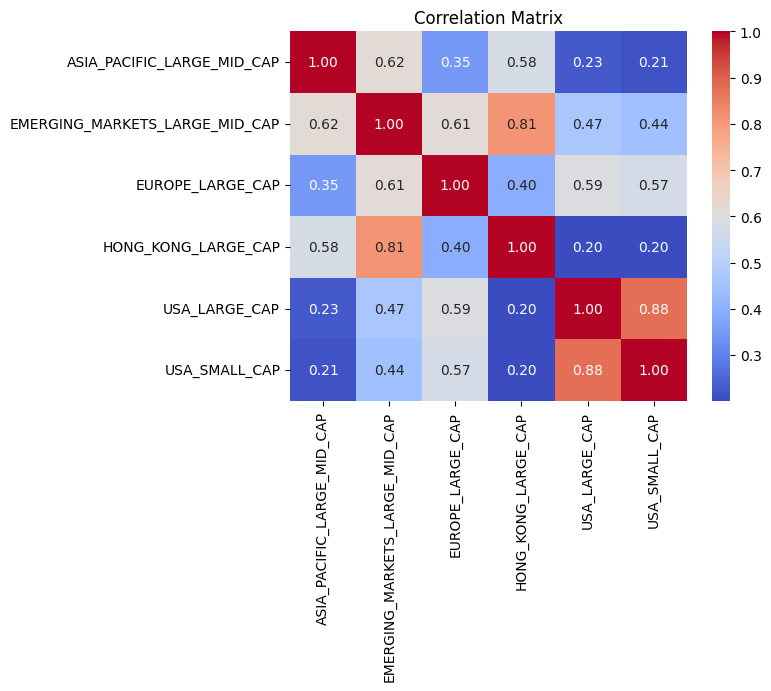

In [6]:
correlation_matrix = log_returns_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

/var/folders/sg/pv5tnjl55557s5fbk3h3ckr80000gn/T/ipykernel_33124/2184456860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_returns_clean.replace([np.inf, -np.inf], np.nan, inplace=True)


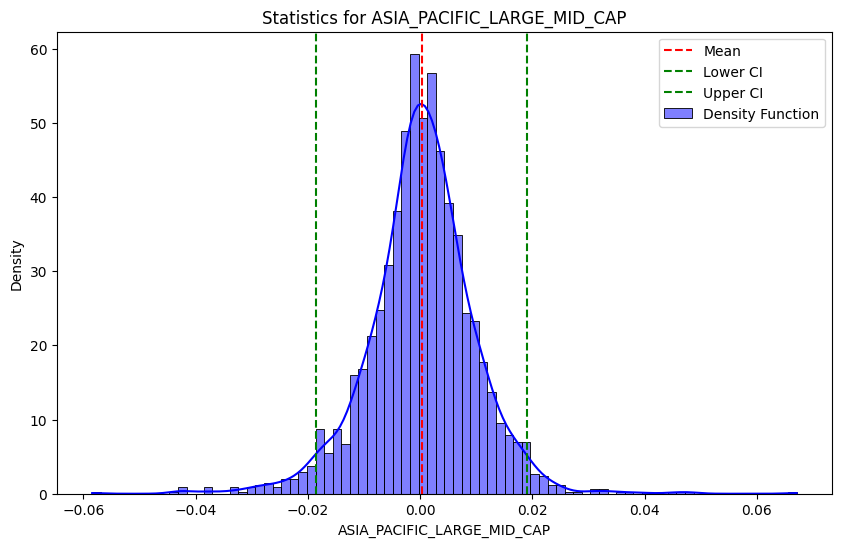

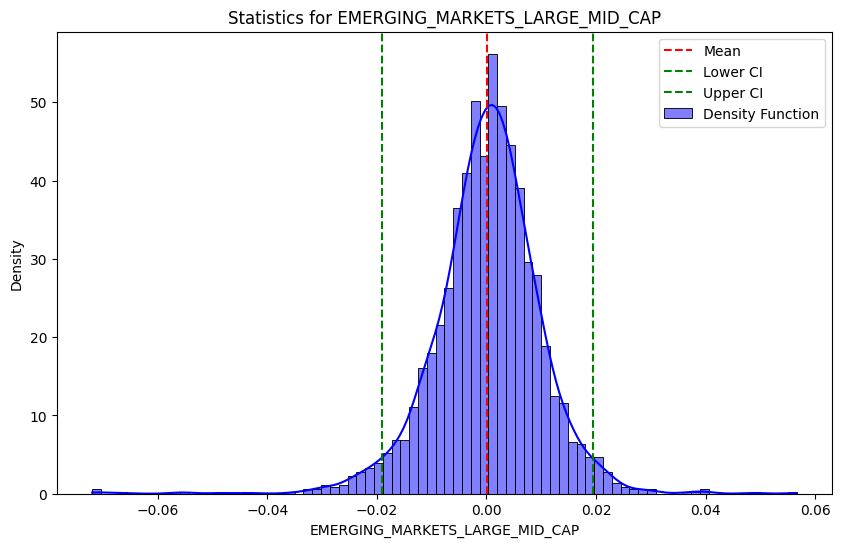

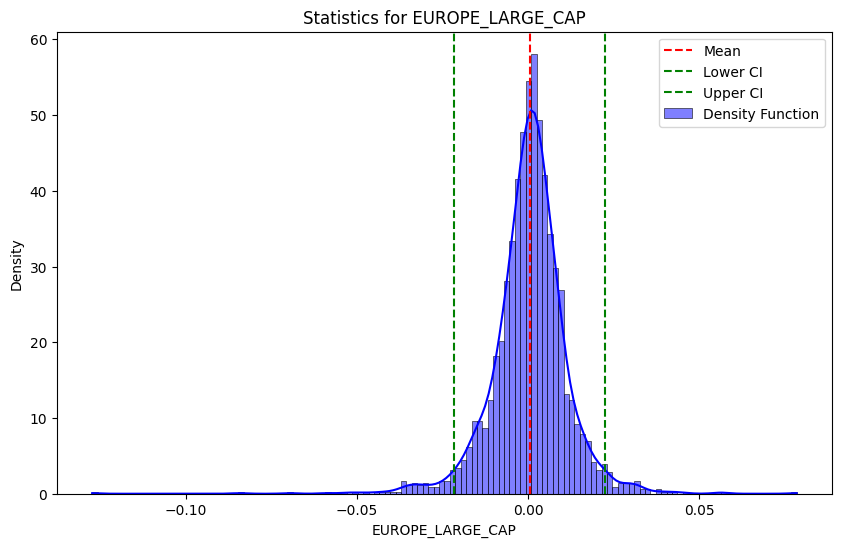

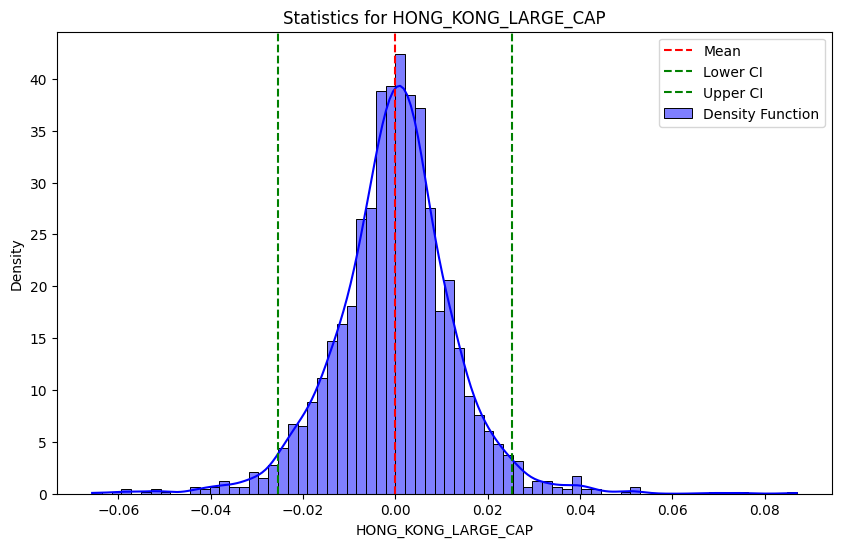

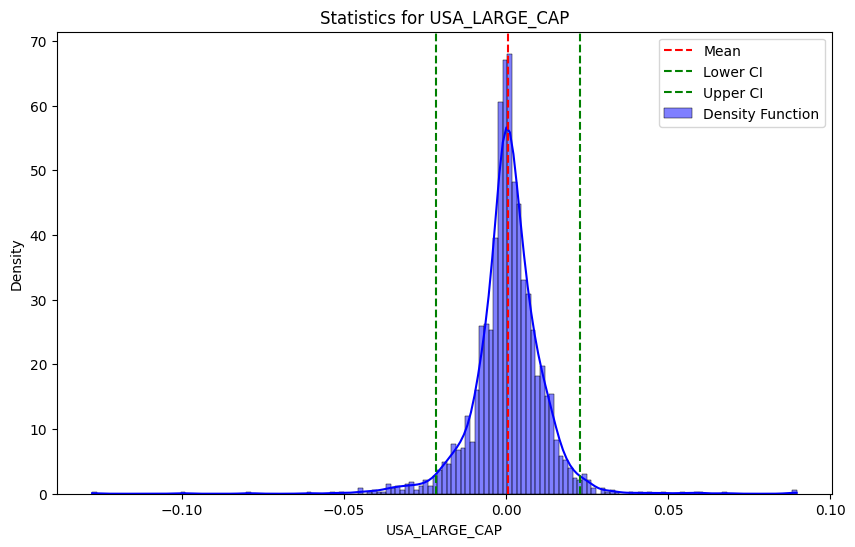

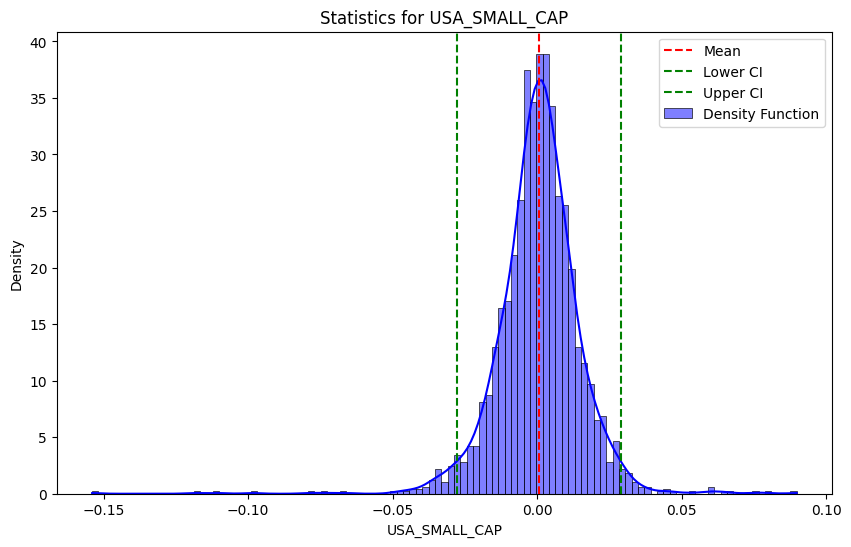

In [8]:
# Replace infinite values with NaN
log_returns_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculate statistics
statistics = log_returns_clean.describe()

# Calculate confidence intervals
confidence_intervals = pd.DataFrame({
    'mean': statistics.loc['mean'],
    'std': statistics.loc['std'],
    'lower_ci': log_returns_clean.mean() - 1.96 * log_returns_clean.std(),
    'upper_ci': log_returns_clean.mean() + 1.96 * log_returns_clean.std()
})

# Visualize statistics
for column in log_returns_clean.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(log_returns_clean[column], kde=True, stat='density', color='blue', label='Density Function')
    plt.axvline(x=statistics.loc['mean', column], color='red', linestyle='--', label='Mean')
    plt.axvline(x=statistics.loc['mean', column] - 1.96 * statistics.loc['std', column],
                color='green', linestyle='--', label='Lower CI')
    plt.axvline(x=statistics.loc['mean', column] + 1.96 * statistics.loc['std', column],
                color='green', linestyle='--', label='Upper CI')
    plt.title(f'Statistics for {column}')
    plt.legend()
    plt.show()

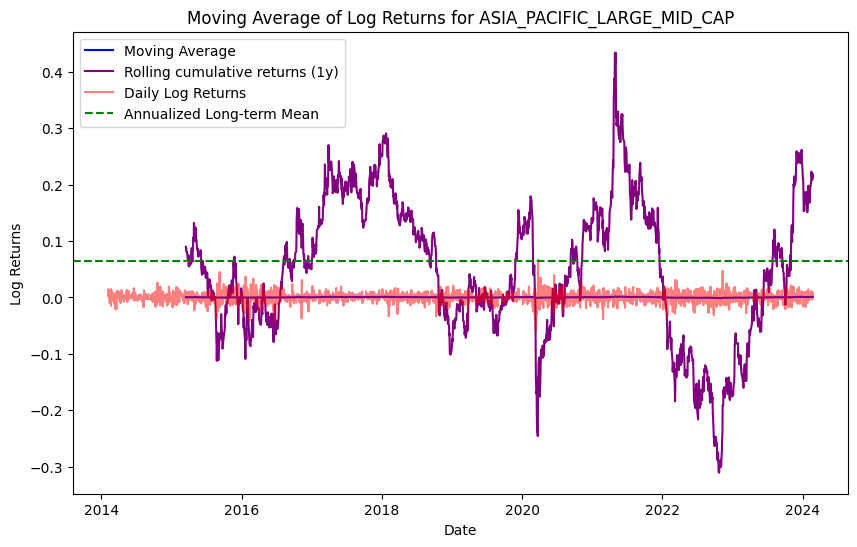

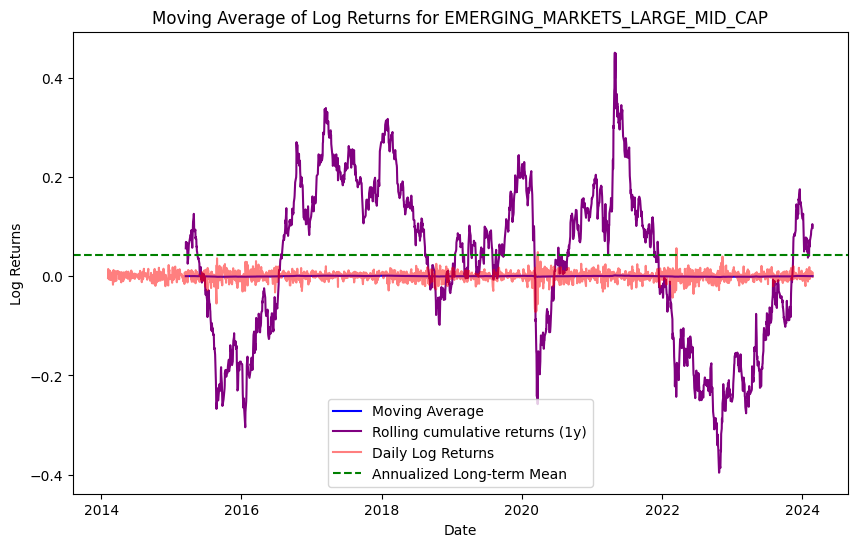

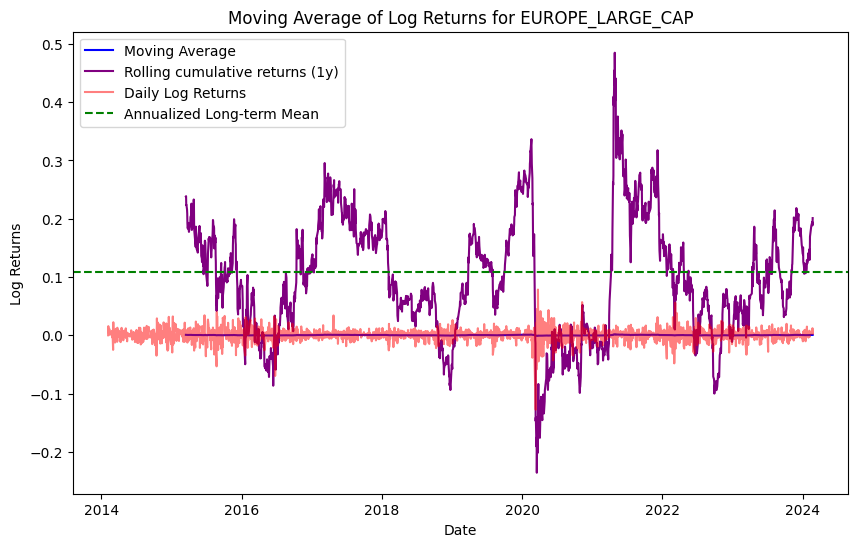

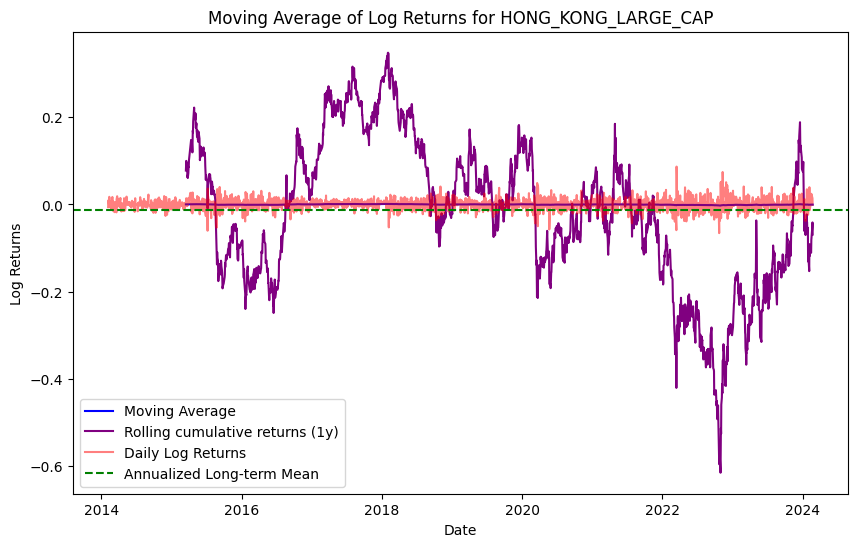

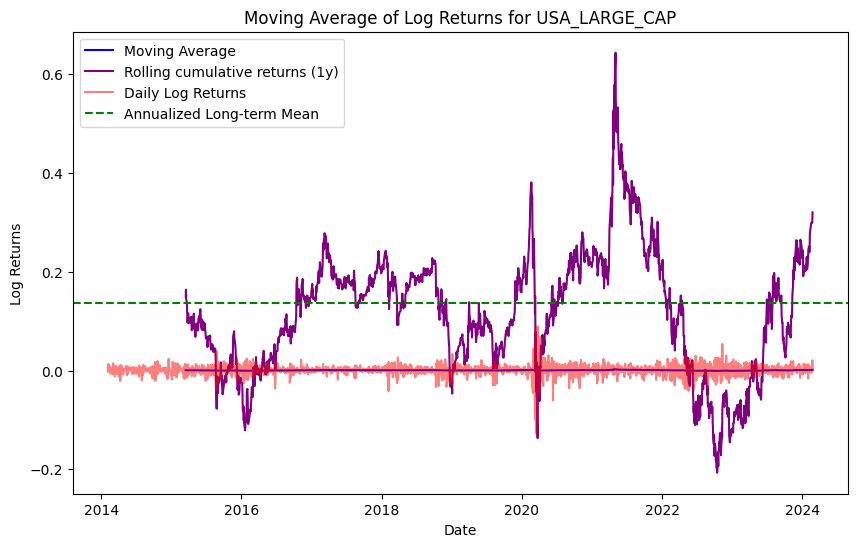

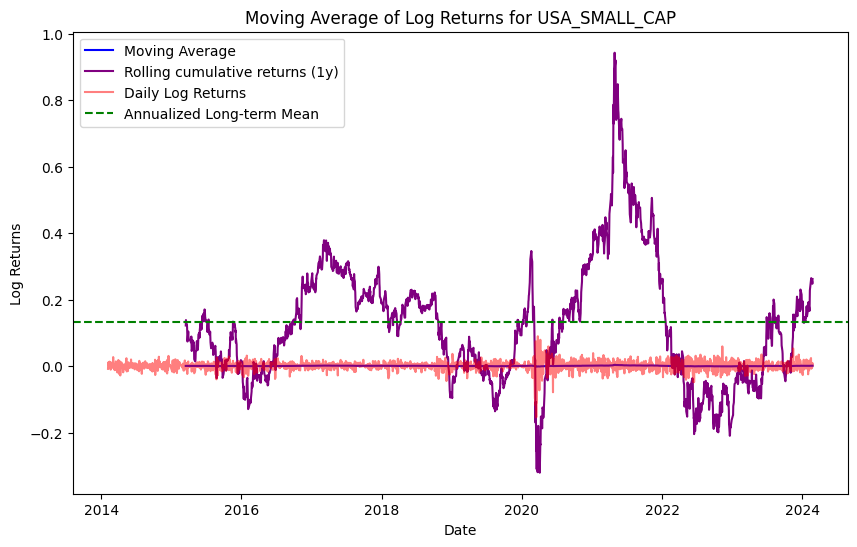

In [14]:
# Calculate the long-term mean estimate for each column
long_term_mean = log_returns_clean.mean() * 252

# Calculate the moving average
moving_avg = log_returns_clean.rolling(window=252).mean()
rolling_cum_1y = log_returns_clean.rolling(window=252).sum()

# Plot the moving average for each column
for column in moving_avg.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(log_returns_clean.index, moving_avg[column], label='Moving Average', color='blue')
    plt.plot(log_returns_clean.index, rolling_cum_1y[column], label='Rolling cumulative returns (1y)', color='purple')
    plt.plot(log_returns_clean.index, log_returns_clean[column], label='Daily Log Returns', color='red', alpha=0.5)
    plt.axhline(y=long_term_mean[column], color='green', linestyle='--', label='Annualized Long-term Mean')
    plt.title(f'Moving Average of Log Returns for {column}')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend()
    plt.show()


In [ ]:
# Calculate the long-term mean estimate for each column
long_term_mean = log_returns_fridays.mean()

# Calculate the moving average with NaN values ignored separately for each column
moving_avg = log_returns_fridays.rolling(window=52, min_periods=40).mean()

# Plot the moving average for each column
for column in moving_avg.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(log_returns_fridays.index, moving_avg[column], label='Moving Average', color='blue')
    plt.plot(log_returns_fridays.index, log_returns_fridays[column], label='Log Returns', color='red', alpha=0.5)
    plt.axhline(y=long_term_mean[column], color='green', linestyle='--', label='Long-term Mean')
    plt.title(f'Moving Average of Log Returns for {column}')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend()
    plt.show()


In [18]:
log_returns_clean.mean()

ASIA_PACIFIC_LARGE_MID_CAP        0.000259
EMERGING_MARKETS_LARGE_MID_CAP    0.000168
EUROPE_LARGE_CAP                  0.000434
HONG_KONG_LARGE_CAP              -0.000052
USA_LARGE_CAP                     0.000541
USA_SMALL_CAP                     0.000524
dtype: float64

In [15]:
from portfolio_allocation import AllocationModel

test = AllocationModel(log_returns = log_returns_clean)
mkw_weights = test.markowitz_portfolio()
output = pd.DataFrame(data = (tickers, mkw_weights)).T
print("Markowitz Optimization: \n", output)

Markowitz Optimization: 
                                 0         1
0      ASIA_PACIFIC_LARGE_MID_CAP  0.252036
1  EMERGING_MARKETS_LARGE_MID_CAP       0.0
2                EUROPE_LARGE_CAP  0.176825
3             HONG_KONG_LARGE_CAP       0.0
4                   USA_LARGE_CAP   0.57114
5                   USA_SMALL_CAP       0.0


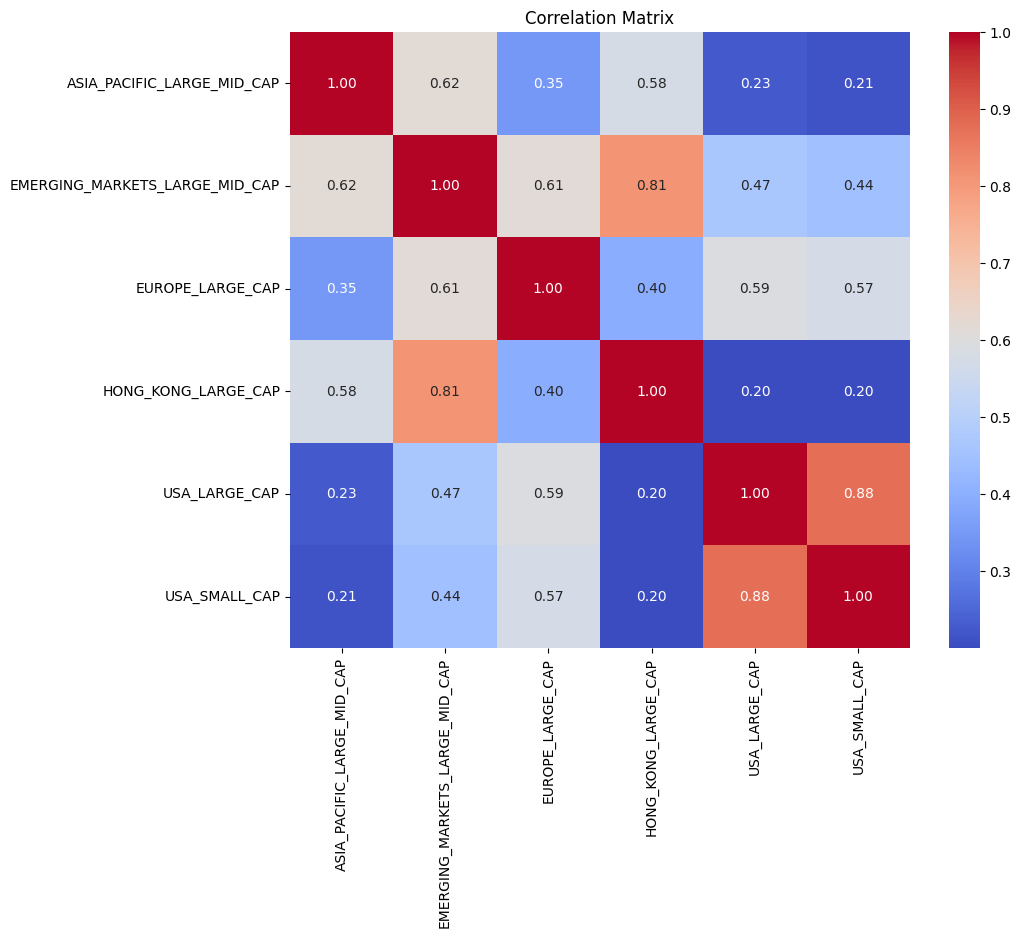

In [21]:
# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

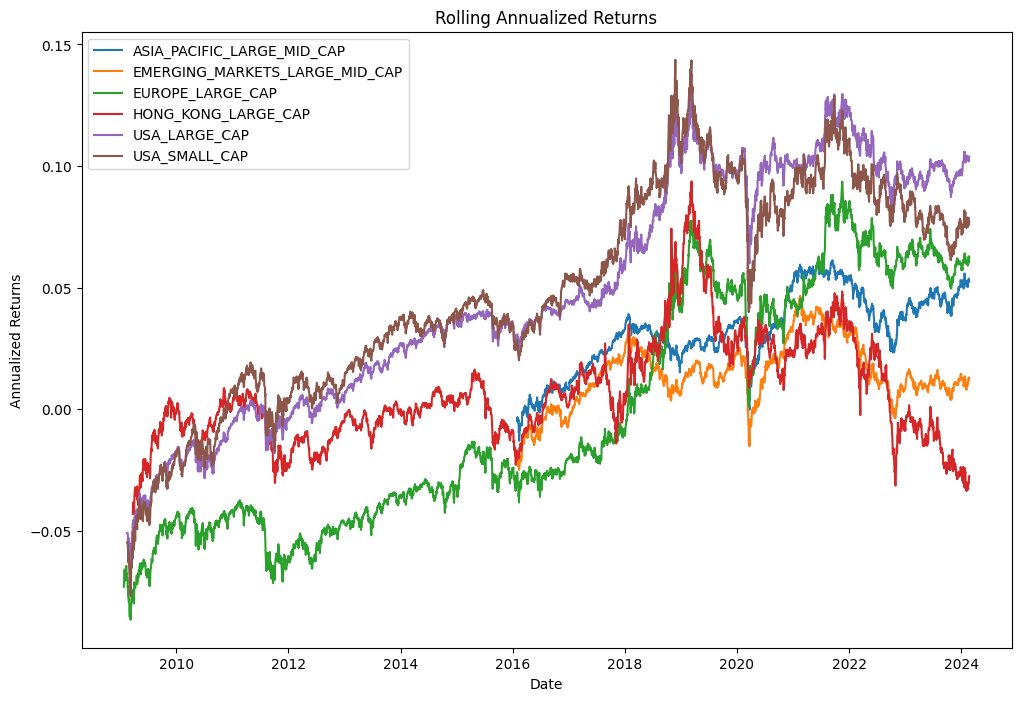

In [15]:
# Define function to calculate annualized returns
def annualized_return(log_returns, window=260):
    return log_returns.rolling(window=window, min_periods = 260*2).sum() * (260 / window)

# Calculate rolling annualized 5-year window log returns
rolling_annualized_returns_df = annualized_return(log_returns, window=10*260)

import matplotlib.pyplot as plt

# Plot each index's rolling annualized returns
plt.figure(figsize=(12, 8))
for col in rolling_annualized_returns_df.columns:
    plt.plot(rolling_annualized_returns_df.index, rolling_annualized_returns_df[col], label=col)

plt.title('Rolling Annualized Returns')
plt.xlabel('Date')
plt.ylabel('Annualized Returns')
plt.legend()
plt.show()

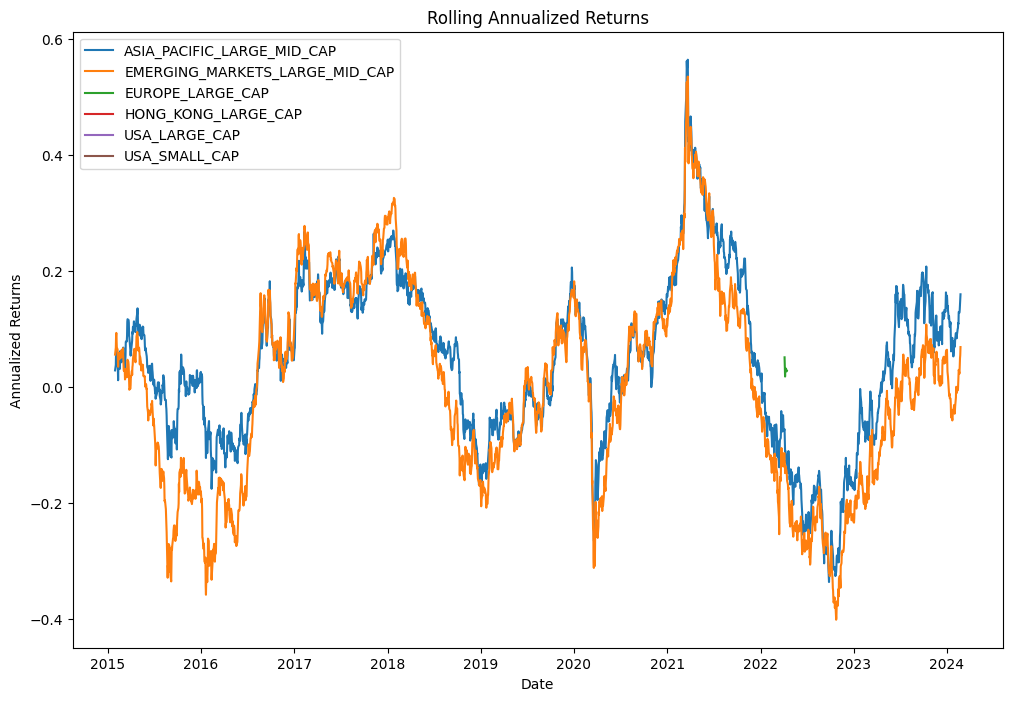

In [ ]:
statistics.loc["count"]

In [ ]:
print(log_returns_fridays)

# EXPECTED RETURNS - ESTIMATION METHOD #1
## -> Simple average of all available observations

In [ ]:
expected_returns_cad = log_returns_adj.apply(lambda x: np.mean(x))
print("Calendar days, daily log-returns:\n\n",expected_returns_cad)
print("\n\nCalendar days, yealy log-returns:\n\n",expected_returns_cad * 252)

In [ ]:
expected_returns_trd = log_returns.apply(lambda x: np.mean(x))
print("Trading days, daily log-returns:\n\n",expected_returns_trd)
print("Trading days, yealy log-returns:\n\n",expected_returns_trd * 365)

In [ ]:
expected_returns_trd_2 = log_returns.apply(lambda x: np.mean(x))
print("Trading days, daily log-returns:\n\n",expected_returns_trd_2)
print("Trading days, yealy log-returns:\n\n",expected_returns_trd_2 * 252)

In [ ]:
# Extracting labels and values
labels = list(expected_returns_cad.keys())
values_cad = list(expected_returns_cad * 252)
values_trd = list(expected_returns_trd * 365)
values_trd_2 = list(expected_returns_trd_2 * 252)

# Plotting
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x, values_cad, width, label='Calendar days')
bars2 = ax.bar([i + width for i in x], values_trd, width, label='Trading days')
bars3 = ax.bar([i + width for i in x], values_trd_2, width, label='Trading days no transform')

# Adding labels and title
ax.set_xlabel('Assets')
ax.set_ylabel('Expected Returns')
ax.set_title('Comparison of Expected Returns')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()